In [1]:
# Standard Data Packages
import pandas as pd
import numpy as np

# Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

#Other Packages
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import shapiro
from sklearn import preprocessing
import joblib

## Load and Check Data

In [2]:
train_df = pd.read_csv("../data/train.csv")

In [3]:
#check number of samples and features
train_df.shape

(165034, 14)

In [4]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
#check data types
train_df.dtypes

id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

In [6]:
#check for null values
train_df.isnull().values.any()

False

In [7]:
#clean and transform string features
train_df["Surname"] = train_df["Surname"].str.strip()
train_df["Surname"] = train_df["Surname"].apply(str.lower) 
train_df["Geography"] = train_df["Geography"].str.strip()
train_df["Geography"] = train_df["Geography"].apply(str.lower) 
train_df["Gender"] = train_df["Gender"].str.strip()
train_df["Gender"] = train_df["Gender"].apply(str.lower) 

## Split Data into Train and Validation Sets

In [8]:
label = train_df["Exited"].values

features = train_df[["CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]].values

#define split percentages
split = (0.7,0.3)
#shuffle dataset
np.random.seed(0)
shuffle = np.random.permutation(np.arange(features.shape[0]))
features, label = features[shuffle], label[shuffle]

#split dataset into train and validation data
splits = np.multiply(len(features), split).astype(int) 
train_features, val_features = np.split(features, [splits[0]])
train_label, val_label = np.split(label, [splits[0]])

In [9]:
#check features' value ranges
train_set = pd.concat([pd.DataFrame(train_features), pd.DataFrame(train_label)], axis=1)

train_set.columns = ["CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Exited"]

for i in train_set.columns:
    display(train_set[i].value_counts())

CreditScore
850    1786
678    1598
684    1212
667    1145
705    1144
       ... 
373       1
423       1
386       1
358       1
419       1
Name: count, Length: 456, dtype: int64

Geography
france     66078
spain      25292
germany    24153
Name: count, dtype: int64

Gender
male      65160
female    50363
Name: count, dtype: int64

Age
37.00    6442
35.00    6421
38.00    6385
36.00    6034
34.00    5964
         ... 
82.00       6
84.00       3
83.00       3
85.00       2
36.44       1
Name: count, Length: 70, dtype: int64

Tenure
2     12576
7     12486
4     12320
8     12283
5     12086
9     11744
1     11726
3     11688
6     11001
10     4118
0      3495
Name: count, dtype: int64

Balance
0.00         62792
124577.33       66
127864.40       48
129855.32       44
102773.20       43
             ...  
104356.46        1
129974.65        1
91843.81         1
146780.47        1
80956.91         1
Name: count, Length: 23229, dtype: int64

NumOfProducts
2    58891
1    54260
3     2048
4      324
Name: count, dtype: int64

HasCrCard
1.0    86999
0.0    28524
Name: count, dtype: int64

IsActiveMember
0.0    58102
1.0    57421
Name: count, dtype: int64

EstimatedSalary
88890.05     131
129964.94     77
140941.47     74
167984.72     74
181224.56     69
            ... 
120591.85      1
108887.22      1
79408.31       1
96663.73       1
92373.42       1
Name: count, Length: 42826, dtype: int64

Exited
0    91072
1    24451
Name: count, dtype: int64

## Histograms

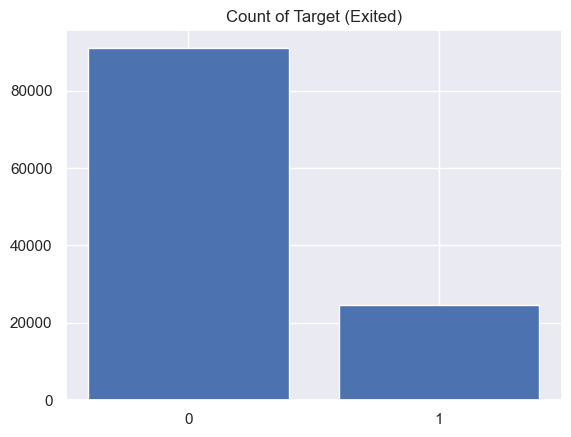

In [10]:
#plot label distribution
plt.bar([0, 1], train_set["Exited"].value_counts().values, tick_label = ["0", "1"])
plt.title("Count of Target (Exited)")
plt.show()

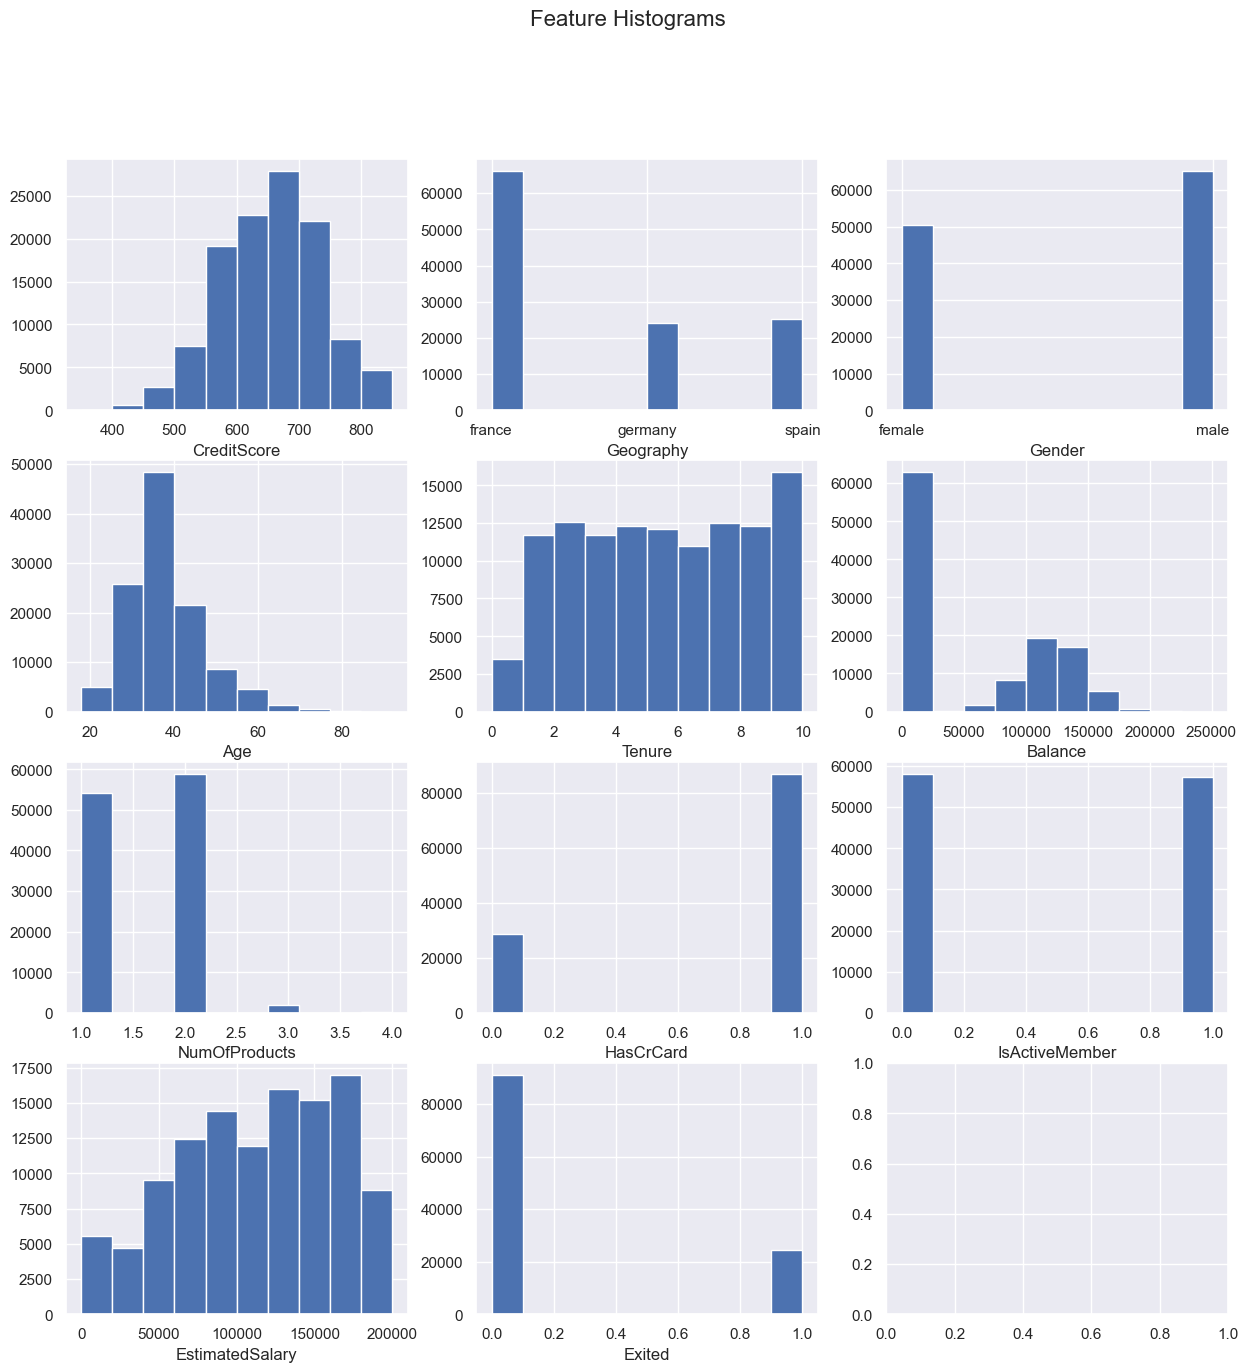

In [11]:
columns = train_set.columns
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
for idx, ax in enumerate(axes.flatten()):
    if idx >= len(columns):
        break
    # plot histogram
    ax.hist(train_set[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])
    
fig.suptitle("Feature Histograms", fontsize=16)
plt.show()

## Normality Test

In [12]:
quantitative_columns = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]

alpha = 0.05

for i in quantitative_columns:
    #perform shapiro test
    stat, p = shapiro(train_set[i])
    if p > alpha:
        print(f'Variable {i} looks Gaussian (fail to reject H0) at {p:.5f}')
    else:
        print(f'Variable {i} does NOT look Gaussian (reject H0)  at {p:.5f}')

/Users/albertkao/anaconda3/envs/tensorflow/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Variable CreditScore does NOT look Gaussian (reject H0)  at 0.00000
Variable Age does NOT look Gaussian (reject H0)  at 0.00000
Variable Tenure does NOT look Gaussian (reject H0)  at 0.00000
Variable Balance does NOT look Gaussian (reject H0)  at 0.00000
Variable NumOfProducts does NOT look Gaussian (reject H0)  at 0.00000
Variable EstimatedSalary does NOT look Gaussian (reject H0)  at 0.00000


## Box Plots

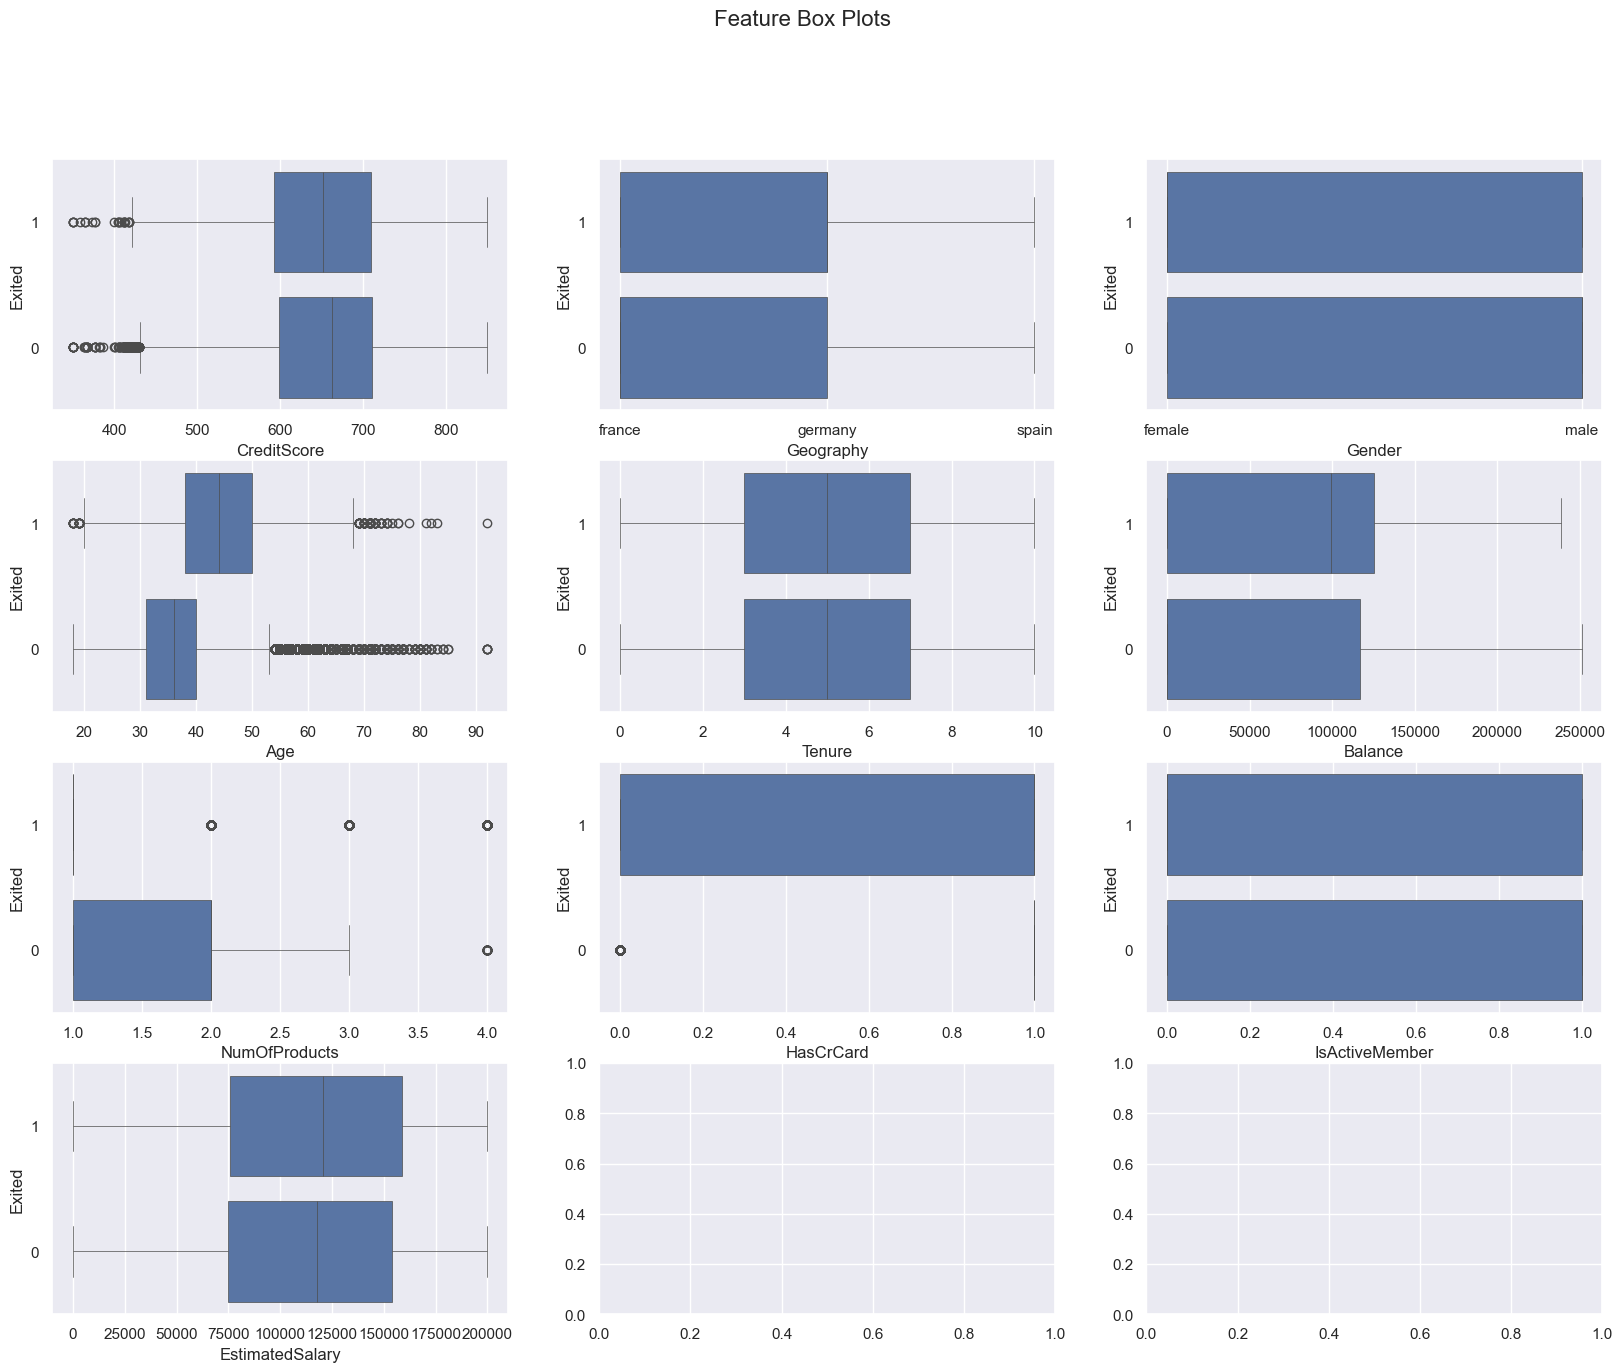

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,15))
for idx, ax in enumerate(axes.flatten()):
    if idx >= (len(columns) - 1):
        break
    feature = train_set[columns[idx]]
    #box plot
    sns.boxplot(x = feature, y = train_set["Exited"], ax = axes[idx // 3][idx % 3], orient='h', linewidth=.5)
    axes[idx//3][idx%3].invert_yaxis()

fig.suptitle("Feature Box Plots", fontsize=16)
plt.show()

## Bar Charts

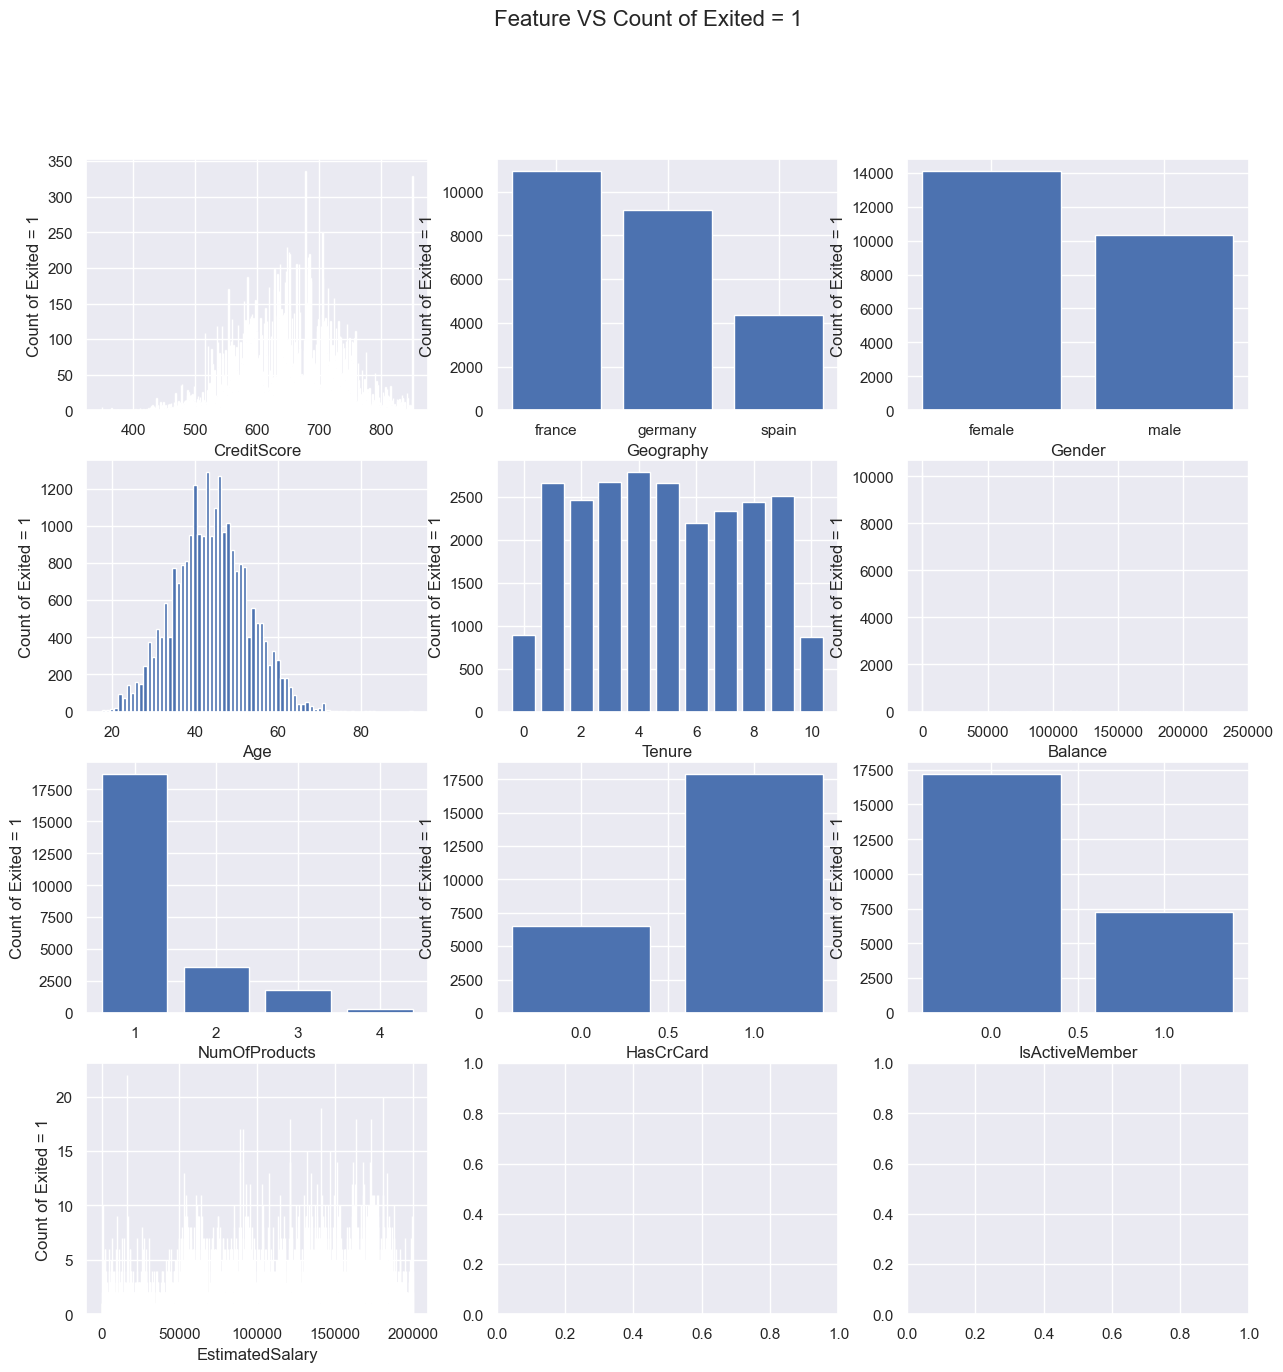

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
for idx, ax in enumerate(axes.flatten()):
    if idx >= (len(columns) - 1):
        break
    temp = train_set[train_set.Exited == 1].groupby(columns[idx]).aggregate("count")["Exited"]
    #plot bar plot
    ax.bar(temp.index, temp.values)
    # set xlabel
    ax.set_xlabel(columns[idx])
    ax.set_ylabel("Count of Exited = 1")

fig.suptitle("Feature VS Count of Exited = 1", fontsize=16)
plt.show()

## Preprocess Data

#### Normalize Numerical Features

In [15]:
train_norm = train_set.copy(deep=True)

#fit scaler on train data
scaler = preprocessing.MinMaxScaler().fit(train_norm[quantitative_columns])
#transform train data
train_norm[quantitative_columns] = scaler.transform(train_norm[quantitative_columns])

#save scaler for later use
joblib.dump(scaler, "../models/scaler_unbalanced.joblib")

train_norm.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.470,france,female,0.472973,0.2,0.000000,0.333333,1.0,1.0,0.459140,0
1,0.512,france,male,0.081081,0.2,0.000000,0.000000,0.0,1.0,0.454370,0
2,0.566,germany,male,0.351351,0.1,0.473928,0.000000,1.0,0.0,0.238851,0
3,0.504,germany,male,0.297297,0.2,0.597701,0.333333,1.0,1.0,0.413466,0
4,0.590,france,male,0.175676,0.4,0.527510,0.000000,1.0,0.0,0.759450,0


#### Encode Categorical Features

In [16]:
categorical_columns = ["Geography", "Gender", "HasCrCard", "IsActiveMember"]

for i in categorical_columns:
    #create encoder for each categorical feature and fit on train data
    label_encoder = preprocessing.LabelEncoder().fit(train_norm[i])
    
    #save each encoder
    encoder_name = f"../models/{i}_encoder_unbalanced.joblib"
    joblib.dump(label_encoder, encoder_name)

    #transform train data
    train_norm[i] = label_encoder.transform(train_norm[i])

train_norm.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.470,0,0,0.472973,0.2,0.000000,0.333333,1,1,0.459140,0
1,0.512,0,1,0.081081,0.2,0.000000,0.000000,0,1,0.454370,0
2,0.566,1,1,0.351351,0.1,0.473928,0.000000,1,0,0.238851,0
3,0.504,1,1,0.297297,0.2,0.597701,0.333333,1,1,0.413466,0
4,0.590,0,1,0.175676,0.4,0.527510,0.000000,1,0,0.759450,0


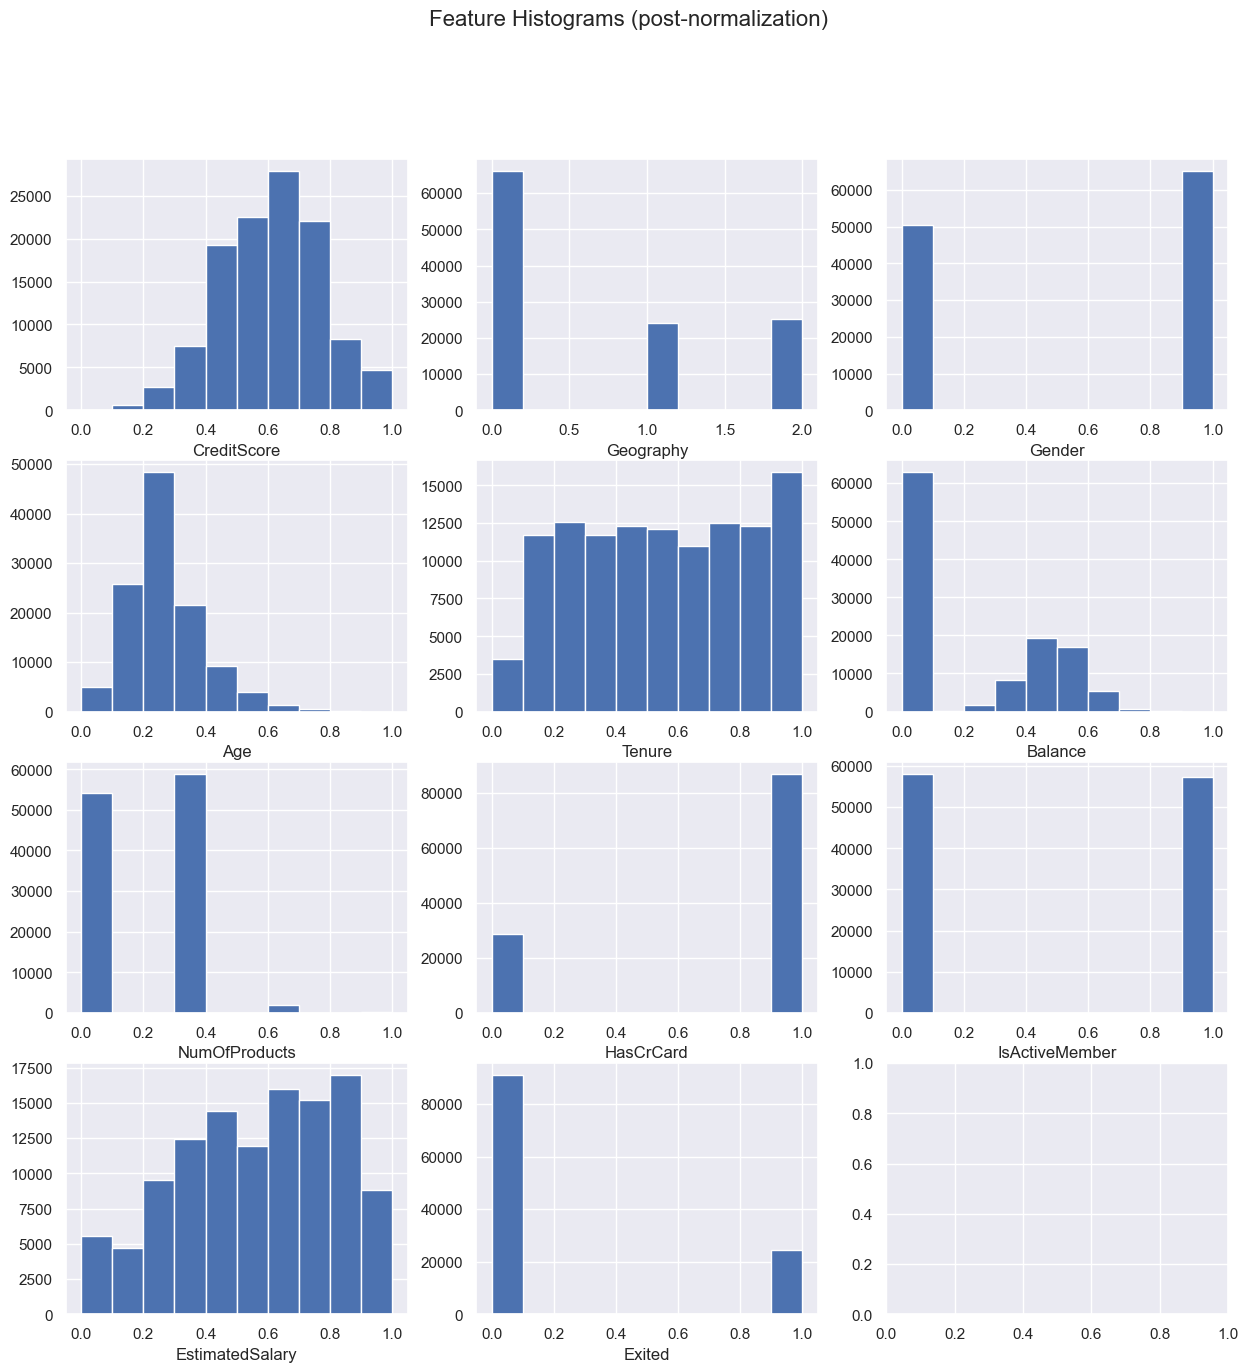

In [17]:
columns = train_norm.columns
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
for idx, ax in enumerate(axes.flatten()):
    if idx >= len(columns):
        break
    # plot histogram
    ax.hist(train_norm[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])

fig.suptitle("Feature Histograms (post-normalization)", fontsize=16)
plt.show()

#### Normalize and Encode Validation Data

In [18]:
val_set = pd.concat([pd.DataFrame(val_features), pd.DataFrame(val_label)], axis=1)

val_set.columns = ["CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Exited"]

#load scaler
scaler = joblib.load("../models/scaler_unbalanced.joblib")

val_norm = val_set.copy(deep=True)

#transform validation data
val_norm[quantitative_columns] = scaler.transform(val_norm[quantitative_columns])

for i in categorical_columns:
    #load encoder
    encoder_name = f"../models/{i}_encoder_unbalanced.joblib"
    label_encoder = joblib.load(encoder_name)

    #transform validation data
    val_norm[i] = label_encoder.transform(val_norm[i])

val_norm.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.624,0,0,0.324324,0.1,0.000000,0.000000,0,1,0.006257,0
1,1.000,1,0,0.108108,0.2,0.584166,0.333333,1,0,0.449359,0
2,0.630,1,0,0.324324,0.0,0.482922,0.000000,1,0,0.732596,1
3,0.706,1,1,0.270270,0.8,0.620729,0.333333,1,0,0.875388,0
4,0.626,2,1,0.216216,0.5,0.000000,0.333333,1,1,0.033752,0


#### Save Data

In [19]:
#save raw and preprocessed data
train_set.to_csv("../data/train_set.csv")
val_set.to_csv("../data/val_set.csv")

train_norm.to_csv("../data/train_norm_set.csv")
val_norm.to_csv("../data/val_norm_set.csv")

## Balance Dataset (undersampled on label)

#### Undersample Train Data

In [20]:
#initialize undersampler
rus = RandomUnderSampler(random_state=42)

features = ["CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]

X_train = train_set[features]
Y_train = train_set["Exited"]

#fit and apply the undersampler to train data
X_train_res, Y_train_res = rus.fit_resample(X_train, Y_train)

In [24]:
X_train_res.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
83999,679,france,male,38.0,8,0.0,2,0.0,1.0,152879.36
56763,581,france,male,39.0,2,0.0,1,1.0,1.0,52827.51
16162,685,spain,male,35.0,8,0.0,2,0.0,0.0,74838.64
110897,613,france,male,38.0,7,0.0,2,0.0,0.0,85982.39
113861,597,france,female,23.0,1,0.0,2,0.0,0.0,126565.21


#### Check Distribution

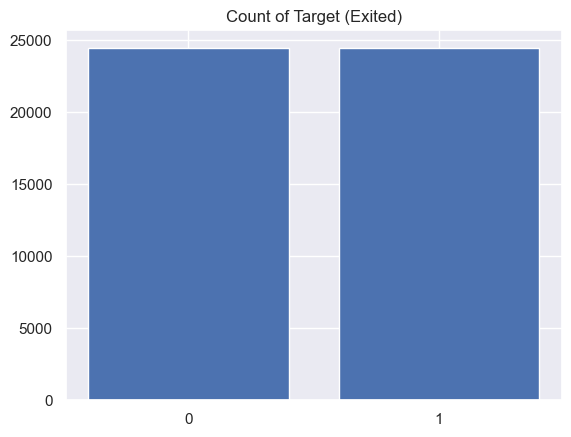

In [21]:
plt.bar([0, 1], Y_train_res.value_counts().values, tick_label = ["0", "1"])
plt.title("Count of Target (Exited)")
plt.show()

#### Undersample Normalized Train Data

In [22]:
X_train_norm_res = X_train_res.copy(deep=True)

#fit scaler on train data
scaler = preprocessing.MinMaxScaler().fit(X_train_norm_res[quantitative_columns])
#transform train data
X_train_norm_res[quantitative_columns] = scaler.transform(X_train_norm_res[quantitative_columns])

#save scaler for later use
joblib.dump(scaler, "../models/scaler_balanced.joblib")

['../models/scaler_balanced.joblib']

In [23]:
for i in categorical_columns:
    #create encoder for each categorical feature and fit on train data
    label_encoder = preprocessing.LabelEncoder().fit(X_train_norm_res[i])
    
    #save each encoder
    encoder_name = f"../models/{i}_encoder_balanced.joblib"
    joblib.dump(label_encoder, encoder_name)

    #transform train data
    X_train_norm_res[i] = label_encoder.transform(X_train_norm_res[i])

X_train_norm_res.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
83999,0.658,0,1,0.270270,0.8,0.0,0.333333,0,1,0.764412
56763,0.462,0,1,0.283784,0.2,0.0,0.000000,1,1,0.264105
16162,0.670,2,1,0.229730,0.8,0.0,0.333333,0,0,0.374171
110897,0.526,0,1,0.270270,0.7,0.0,0.333333,0,0,0.429895
113861,0.494,0,0,0.067568,0.1,0.0,0.333333,0,0,0.632829


## Save Undersampled Data

In [25]:
train_set_balanced = pd.concat([X_train_res, Y_train_res], axis = 1)
train_norm_balanced = pd.concat([X_train_norm_res, Y_train_res], axis = 1)

In [26]:
train_set_balanced.to_csv("../data/train_set_balanced.csv")
train_norm_balanced.to_csv("../data/train_norm_balanced.csv")